## Data Curation Part 2

In [37]:
#import packages 
import os 
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np 
import pickle

In [3]:
#import environment variables 
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [4]:
#log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
#one more import after HF login
from items import Item

## The ItemLoader code

In [6]:
#load appliances dataset
items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████| 95/95 [00:35<00:00,  2.68it/s]


Completed Appliances with 30,016 datapoints in 0.6 mins


In [7]:
#look for familiar item
print(items[0])
print(items[1])
print(items[2])

<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>
<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>
<Chenhon Fridge Handle Cover-Catches Drips,Door Cloth Protector,(1 Pair) (Green) = $8.89>


In [8]:
#look for items prompt
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


## Now to SCALE UP

In [9]:
#now i am going to be bring in rest of the appliance from the amazon dataset on hugging face 
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [10]:
#use same item loader method created earlier
items = []
for dataset_name in dataset_names:
    loader=ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


100%|██████████| 2004/2004 [20:27<00:00,  1.63it/s]


Completed Automotive with 947,830 datapoints in 20.8 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [13:34<00:00,  1.98it/s]


Completed Electronics with 454,613 datapoints in 13.9 mins
Loading dataset Office_Products


100%|██████████| 711/711 [05:10<00:00,  2.29it/s]


Completed Office_Products with 246,745 datapoints in 5.3 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████| 1474/1474 [14:19<00:00,  1.72it/s]


Completed Tools_and_Home_Improvement with 552,296 datapoints in 14.7 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████| 1289/1289 [08:09<00:00,  2.63it/s]


Completed Cell_Phones_and_Accessories with 240,374 datapoints in 8.4 mins
Loading dataset Toys_and_Games


100%|██████████| 891/891 [07:10<00:00,  2.07it/s]


Completed Toys_and_Games with 348,609 datapoints in 7.4 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:59<00:00,  1.59it/s]


Completed Appliances with 30,016 datapoints in 1.1 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [01:35<00:00,  2.25it/s]


Completed Musical_Instruments with 69,275 datapoints in 1.7 mins


In [11]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,889,758 items


In [12]:
#save to local
import pandas as pd
rows = [vars(item) for item in items]  # get all fields from each Item
df = pd.DataFrame(rows)
df.to_csv("all_amazon_items.csv", index=False)

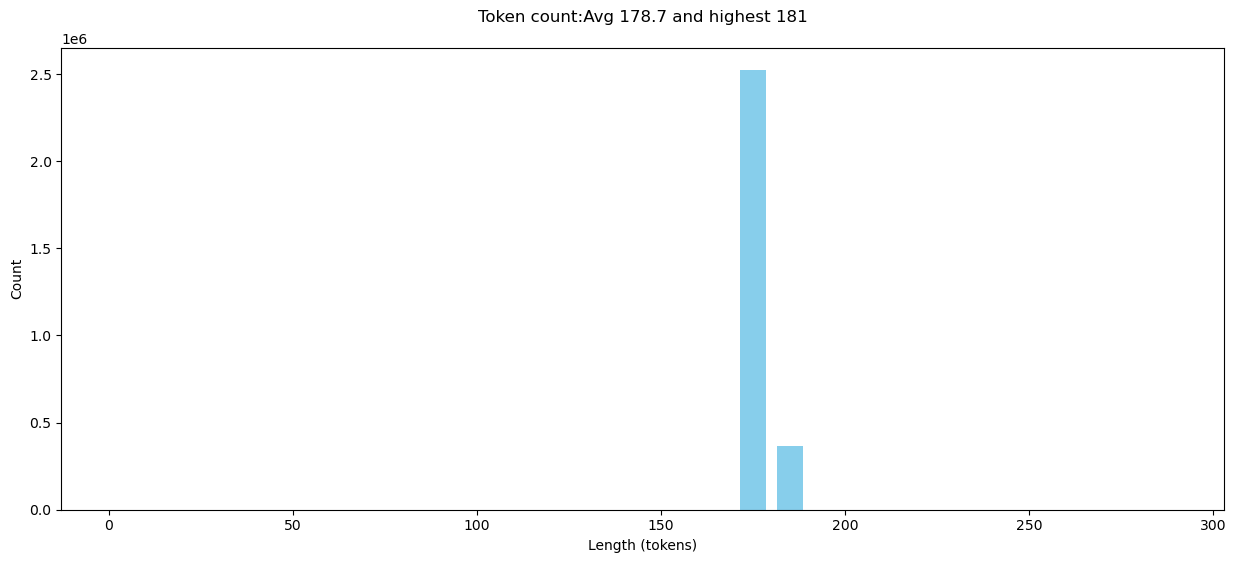

In [13]:
#plot the distribution of tokens
tokens = [item.token_count for item in items]
plt.figure(figsize = (15,6))
plt.hist(tokens,rwidth=0.7, color="skyblue", bins= range(0,300,10))
plt.title(f"Token count:Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel("Length (tokens)")
plt.ylabel("Count")
plt.show()

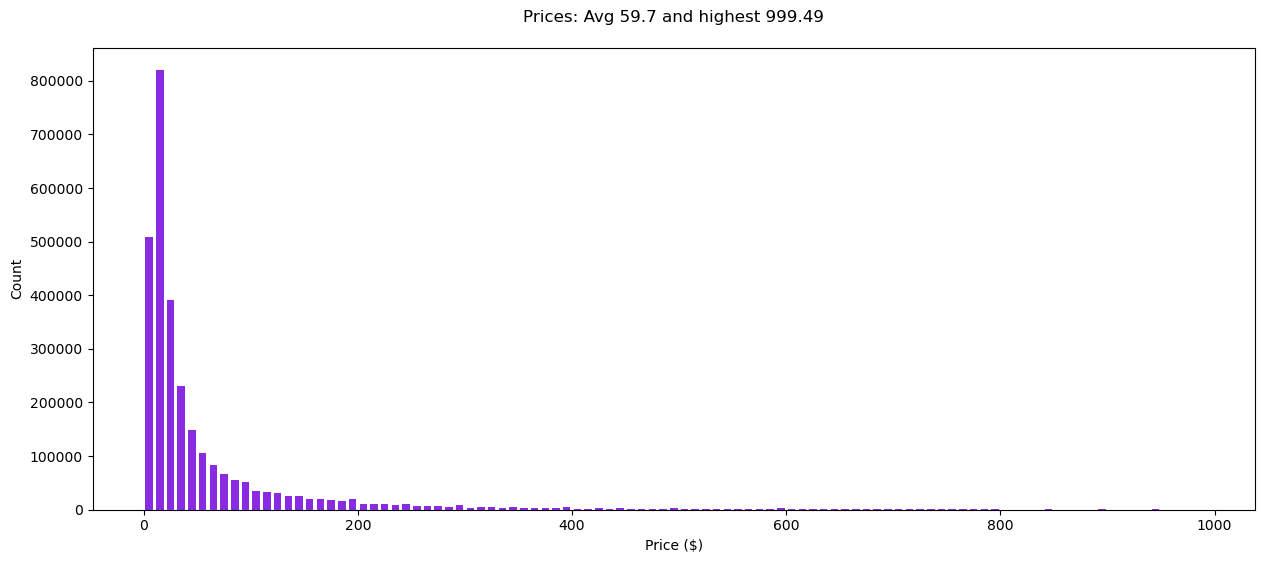

In [14]:
#plot the distribution of price
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.show()

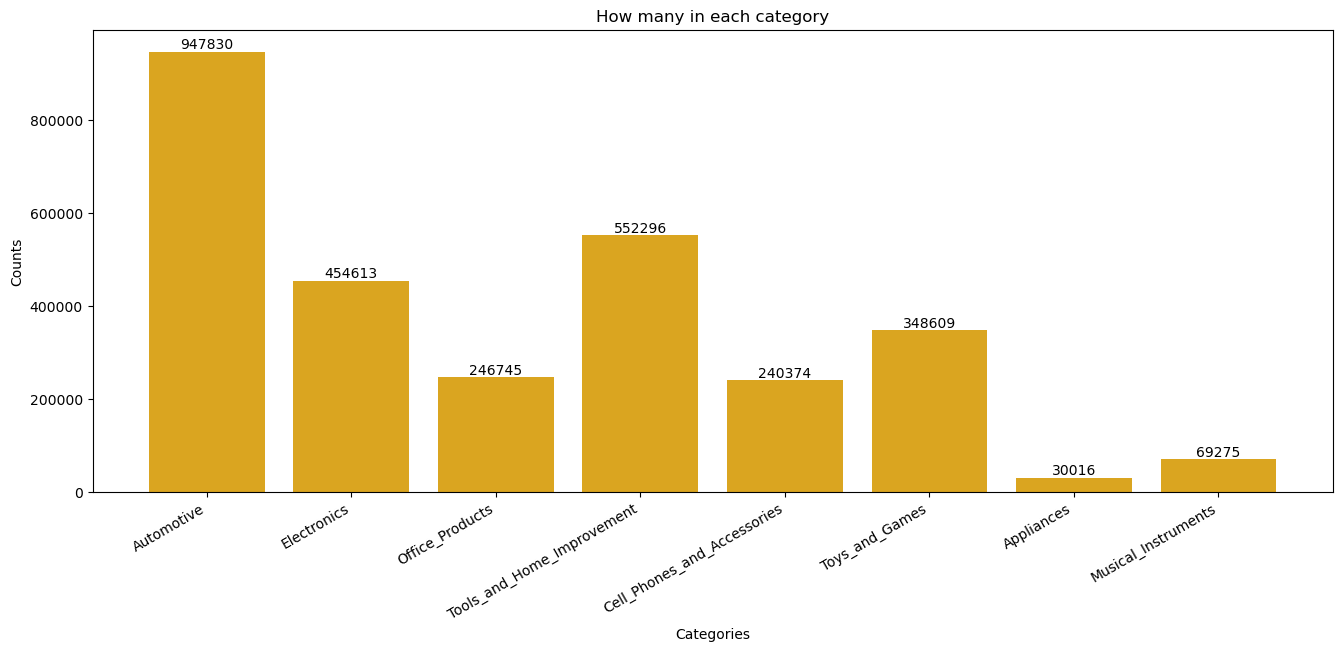

In [15]:
# Let's see the categories

#set a counter for all categories 
category_count = Counter()
#iterate through all categories
for item in items:
    category_count[item.category] +=1

#handpick the category name for plotting
categories = category_count.keys()
counts=[category_count[category] for category in categories]

#create a bar chart for all categories 
plt.figure(figsize=(16,6))
plt.bar(x=categories, height=counts, color="goldenrod" )
plt.title("How many in each category")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.xticks(rotation= 30,ha="right")

#add value labels on top of each bar 
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:}", ha="center", va="bottom")

plt.show()

- Automative data is making the whole dataset skewed

## Dataset Manipulation
- As we can see the dataset is not quite balance so balancing has to be done also keep fewer Automative items

In [16]:
#create a dict with a key of each prices from $1 to $999
#and in the value, put a list of items with that price (to nearest round number)

slots=defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [17]:
#create a dataset called "sample" 
#which tries to more evenly take from the range of prices
#and gives more weight to items from categories other than Automative
#set a random seed for reproducibility 

np.random.seed(42)
random.seed(42)

sample = []
for i in range(1,1000):
    slot = slots[i]
    if i>=240:                  #set threshold
        sample.extend(slot)     #pull it in
    elif len(slot)<=1200:       #set threshold
        sample.extend(slot)     #pull it in
    else:
        weights = np.array([1 if item.category=="Automotive" else 5 for item in slot])
        weights = weights/np.sum(weights)

        #"p=weights" will help in balancing the categories
        selected_indices =np.random.choice(len(slot), size=1200,replace=False,p=weights) 
        selected=[slot[i] for i in selected_indices]
        sample.extend(selected)     #pull it in

print(f"There are {len(sample):,} items in the sample")

There are 413,726 items in the sample


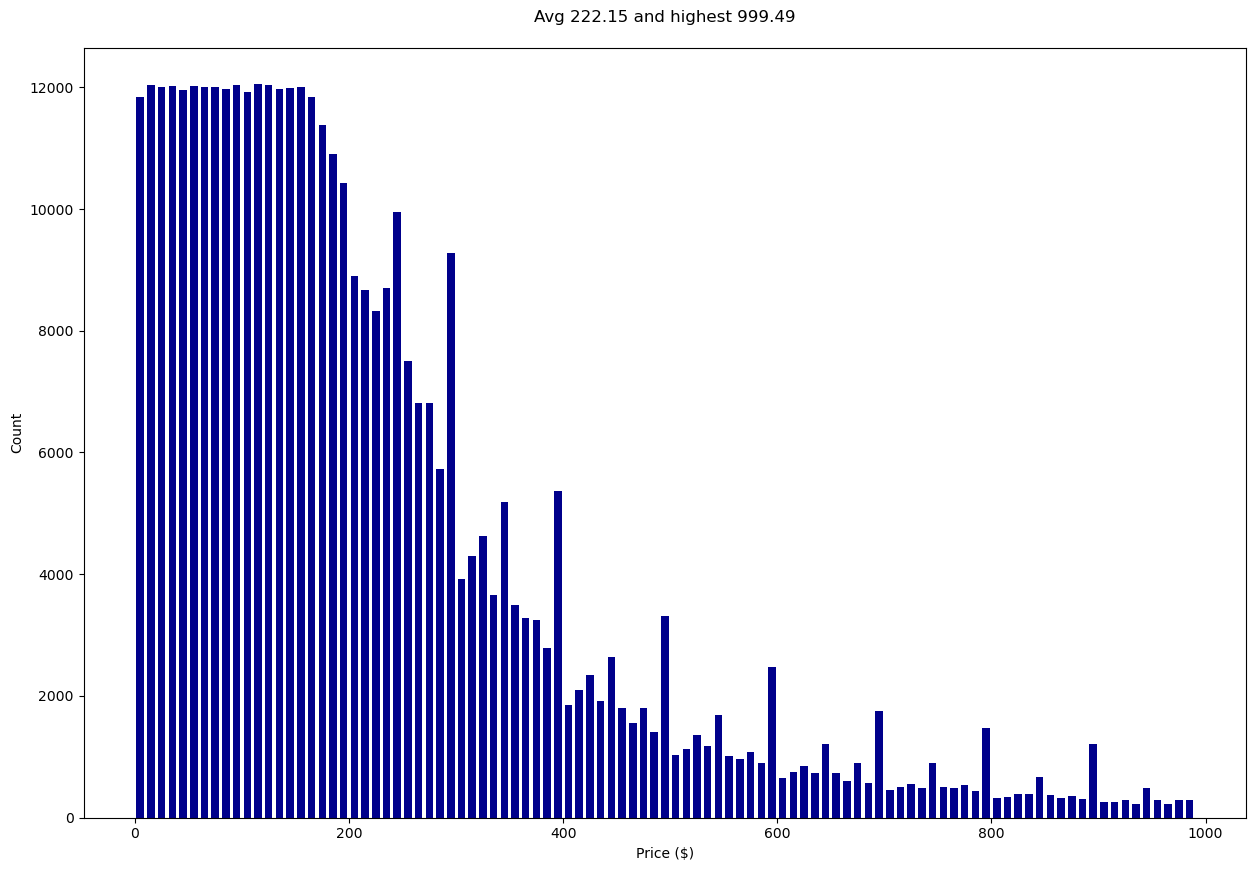

In [18]:
#Again, plot the distribution of prices in sample 
prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

- It can be seen that the data is better distributed now atleast better than before 

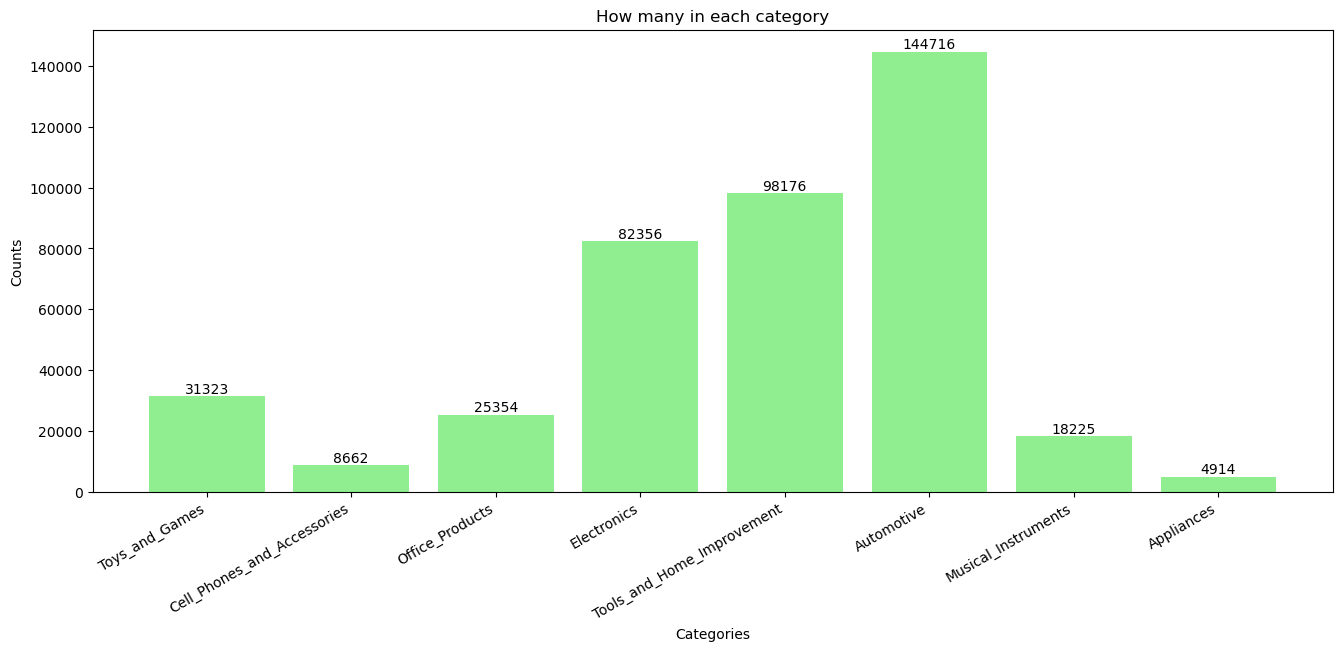

In [19]:
# Again,Let's see the categories

#set a counter for all categories 
category_count = Counter()
#iterate through all categories
for item in sample:
    category_count[item.category] +=1

#handpick the category name for plotting
categories = category_count.keys()
counts=[category_count[category] for category in categories]

#create a bar chart for all categories 
plt.figure(figsize=(16,6))
plt.bar(x=categories, height=counts, color="lightgreen" )
plt.title("How many in each category")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.xticks(rotation= 30,ha="right")

#add value labels on top of each bar 
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:}", ha="center", va="bottom")

plt.show()

- Categories also seem better now. not a lot of distortion is done to mimic real world data
- Automative is bit under control now 

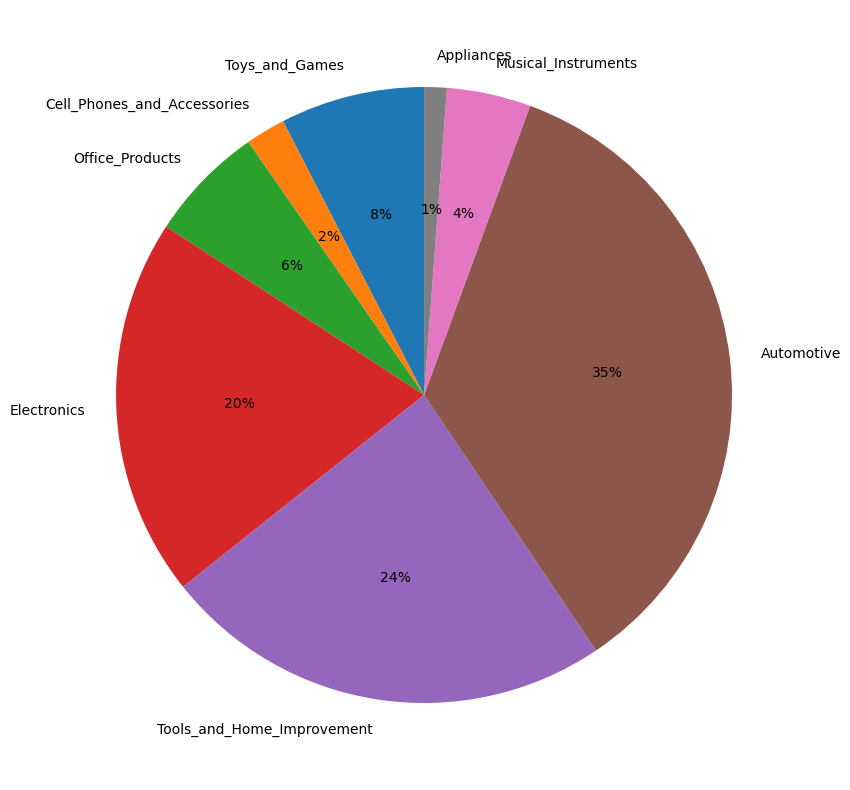

In [20]:
#lets make a pie chart now 
plt.figure(figsize=(12,10))
plt.pie(counts,labels=categories, autopct='%1.0f%%', startangle=90)
plt.show()

# Final Dataset Curated

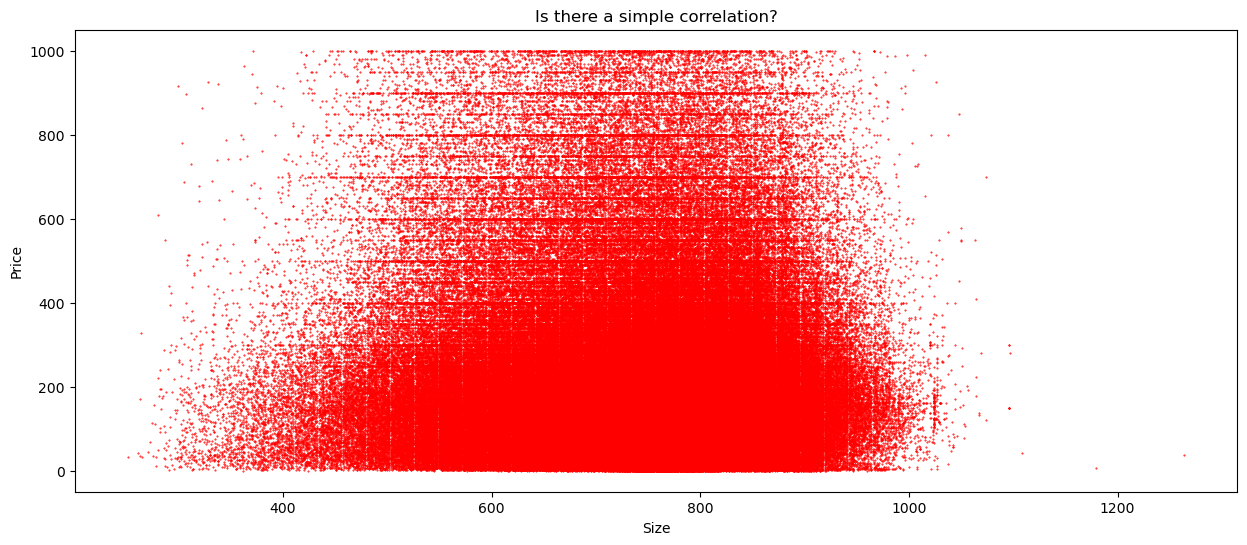

In [ ]:
#lets see how does the price vary with characters count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

#create the scatter plot
plt.figure(figsize=(15,6))
plt.scatter(sizes, prices, s=0.2, color="red")

#add labels and titles 
plt.xlabel("Size")
plt.ylabel("Price")
plt.title("Is there a simple correlation?")

plt.show()

In [ ]:
def report(item):
    prompt = item.prompt
    tokens= Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:]) #last 10
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [27]:
report(sample[398000])

How much does this cost to the nearest dollar?

XTOOL D8 Car Diagnostic Scanner 2023 Newest with 3 Years Updates, Bidirectional Scan Tool with CAN FD, ECU Coding, 38+ Resets, Key Programming, Crankshaft Sensors Relearn, Full System Diagnostics
A Reliable & Affordable ALL-IN-ONE Car Diagnostic Scanner 2023 Newest Version XTOOL D8 scanner features Advance ECU Coding & Online Coding, Full Bi-Directional Controls, OE-Level All Systems Diagnose, 38+ Resets, Key Programming, supports CAN FD protocol for GM 2020MY and forward cars, it equipped with premium hardware for fast multitasking. XTOOL D8 would really come in handy if you have your own auto repair shop, it is also perfect for

Price is $699.00
[271, 6972, 374, 400, 21, 24, 24, 13, 15, 15]
['\n\n', 'Price', ' is', ' $', '6', '9', '9', '.', '0', '0']


### Split Train, Val and Test Dataset

In [29]:
#training  i will set 400,000 and 2000 will be set fro testing
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into training set of {len(train):,} items and test set of {len(test):,} items")

Divided into training set of 400,000 items and test set of 2,000 items


In [30]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Star Micronics USB Thermal Receipt Printer with Device and Mfi USB Ports, Auto-cutter, and Internal Power Supply - Gray (Renewed)
High-speed printing of 43 receipts per minute with easy to setup USB connection - just Plug and Print; USB serial number feature means the PC will detect the on its Windows platform using any USB port Includes PromoPRNT promotion printing service allowing you to automatically create printed promotions in addition to receipts Drop-In and Print clamshell design allows for fast and easy paper loading; patented De-Curl function always delivers a flat receipt futurePRNT Software allows you to customize receipts to keep customers coming back time and time again with professional graphics (logos, coupons), word-triggered advertising, and more The small footprint and embedded power supply saves precious counter space Brand Star Mic

Price is $207.00


In [31]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Sena Bluetooth Headset and Intercom with Built-In FM Tuner for Scooters/Motorcycles with Universal Microphone Kit, Black, Single
SMH5 Bluetooth Headset & Intercom with built-in FM tuner for Scooters and Motorcycles with Universal Microphone Kit. Bluetooth 3.0 Crystal clear and natural sound quality Can be used while charging on road trips Individual volume control for each audio source Firmware upgradeable Brand Sena, Model Name Color Black, Form Factor On Ear, Connectivity Technology Wireless, Is Discontinued No, Dimensions 2.75 x 1.77 x 1.2 inches; 1.41 Ounces, model number Department Unisex-adult, Batteries Lithium Metal batteries required. (included), Available January 20

Price is $


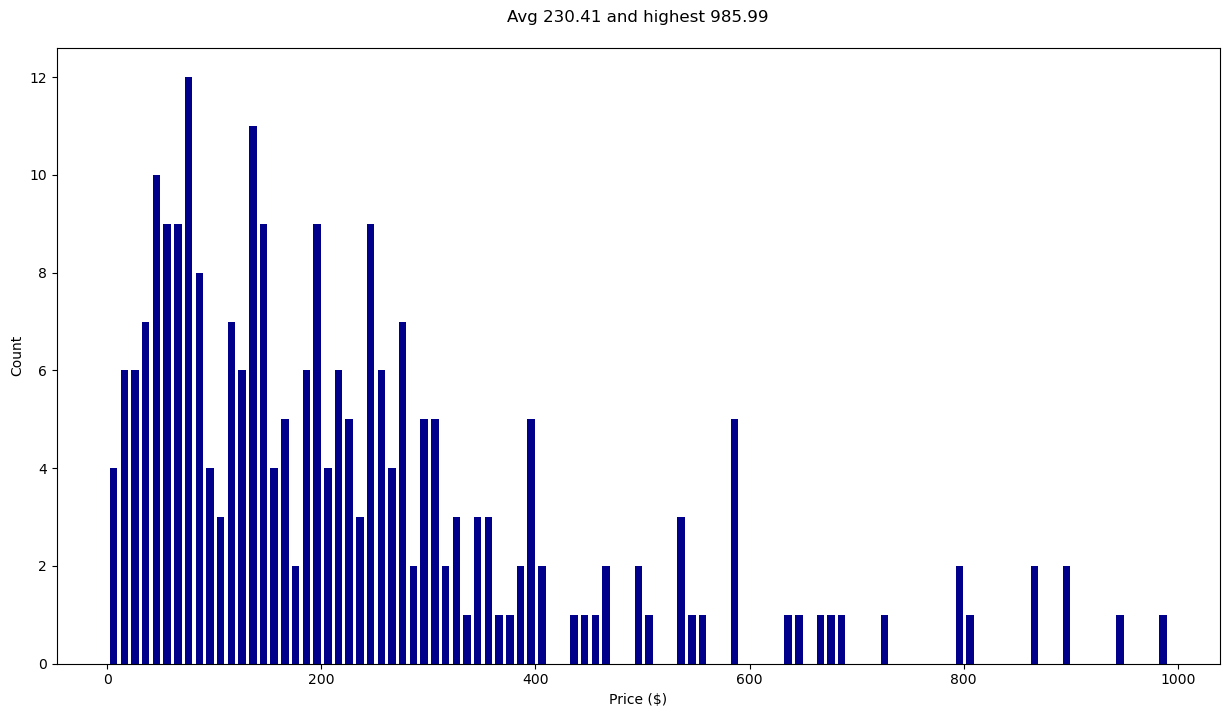

In [34]:
#plot the distribultion of 250 points
prices= [float(item.price) for item in test[:250]]
plt.figure(figsize = (15,8))
plt.hist(prices, rwidth = 0.7, color= "darkblue", bins = range(1,1000,10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()

## Final Dataset
-Convert to prompts and upload to HuggingFace hub

In [39]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [40]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [41]:
# Uncomment these lines if you're ready to push to the hub, and replace my name with your HF username

HF_USER = "akankshakusf"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/akankshakusf/pricer-data/commit/bc85a911a5237d53bac7eed3c4c1e4482415e6d9', commit_message='Upload dataset', commit_description='', oid='bc85a911a5237d53bac7eed3c4c1e4482415e6d9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/akankshakusf/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='akankshakusf/pricer-data'), pr_revision=None, pr_num=None)

In [42]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)